# Link Prediction Tutorial
This notebook guides you through several methods for predicting missing links in a network. Each code cell is explained with comments to help you understand what is happening, even if you are new to programming.

In [ ]:
## Install extra packages on Google Colab  ───────────────────────────────────
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


# # Locally (there may be some version conflicts even with this)
# #!mamba install -c conda-forge -c pytorch scikit-learn pytorch_geometric pytorch networkx pandas matplotlib -y
# #!pip install node2vec

In [ ]:
# 1. Imports  ─────────────────────────────────────────────────────────────────-
# -----------------------------------------------------------------------------
import networkx as nx                              # graphs
import pandas as pd                                # tables (DataFrames)
import numpy  as np                                # maths
import itertools                                   # handy loops / cartesian products
import pylab as plt                                # plots

# ML helpers
from sklearn.metrics        import roc_auc_score, RocCurveDisplay, classification_report
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import LogisticRegressionCV

# Embeddings
from sklearn.decomposition  import TruncatedSVD
#from node2vec               import Node2Vec

# Graph-NN bits
import torch, torch.nn as nn, torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn   import SAGEConv
from torch_geometric.utils import negative_sampling

pd.options.mode.chained_assignment = None          # hush pandas warning

/Users/garci061/miniforge3/envs/networks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction
We will use a protein-protein interaction network from yeast and a Twitter network.
You can switch between them by changing the `network` variable below.

In [ ]:
## Pick data set and load the network
network   = "twitter"                              # change to "ppi" for yeast

# Read network (download it from internet) 
## ONLY IN COLAB! (otherwise use the data from the Data folder, no need to download)
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction.graphml 
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction_test.csv


#path_data = "../../Data/"                          # locally
path_data = "./"                                   # on google colab
path_net  = f"{path_data}/{network}_network_prediction.graphml"

# read the GraphML file with NetworkX
G = nx.read_graphml(path_net) if network != "ppi" else nx.read_graphml(path_net, node_type=int)
print(f"Loaded graph with {G.number_of_nodes():,} nodes and {G.number_of_edges():,} edges")


Loaded graph with 1,554 nodes and 24,631 edges


### Visualize the network and print basic properties

Global clustering: 0.17180199363203535
Degree assortativity: -0.033464131292299366


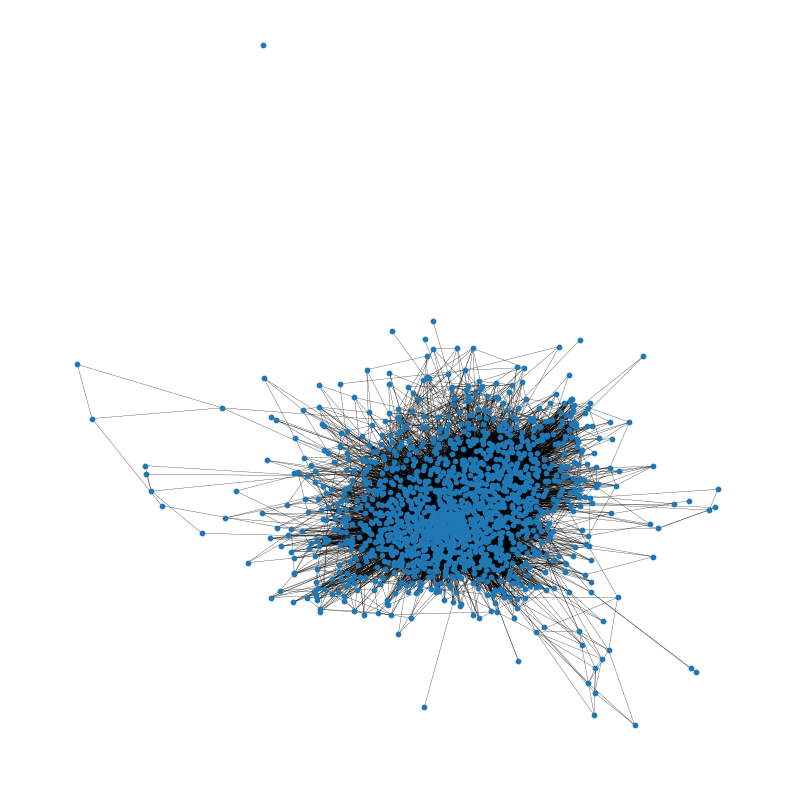

In [4]:
## Quick visual check of the network  

fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=ax, node_size=10, width=.2)
print('Global clustering:', nx.transitivity(G))
print('Degree assortativity:', nx.degree_assortativity_coefficient(G))

In [ ]:
## Build the training edge list (`df_edgelist`)  ────────────────────────────

# Step-1: every possible *ordered* pair of nodes, incl. self-loops
all_pairs           = list(itertools.product(G.nodes(), repeat=2))
df_edgelist         = pd.DataFrame(all_pairs)          # columns 0 (src), 1 (dst)

# Step-2: mark the pairs that are REAL edges (edge == 1)
df_edges            = pd.DataFrame(G.edges(), columns=[0, 1])
df_edges["edge"]    = 1                                # label = 1
df_edgelist         = df_edgelist.merge(df_edges, how="left").fillna({"edge": 0})

# keep a version **without self-loops** for downstream stacking
df_no_loops         = df_edgelist[df_edgelist[0] != df_edgelist[1]].copy()

print("Training edge list built:", df_edgelist.shape)
display(df_edgelist.head())


## Load the hidden test pairs (`df_test`)
df_test = pd.read_csv(f"{path_data}/{network}_network_prediction_test.csv",
                      sep="\t", index_col=0)
df_test.columns = [0, 1, "label"]                    # rename for consistency
# Add node labels
d_conv_inv = nx.get_node_attributes(G, "label")
df_test["source"] = df_test[0].astype(str).map(d_conv_inv)
df_test["target"] = df_test[1].astype(str).map(d_conv_inv)

if network == "twitter":                             # make sure IDs are strings
    df_test[[0, 1]] = df_test[[0, 1]].astype(str)
df_test.drop_duplicates(subset=[0, 1], inplace=True)
print("Hidden test set:", df_test.shape)
display(df_test.head())

Training edge list built: (2414916, 3)


,0,1,edge
0,0,0,0.0
1,0,1,1.0
2,0,217,1.0
3,0,476,1.0
4,0,1324,1.0


Hidden test set: (12152, 5)


,0,1,label,source,target
0,448,37,1,NaN,NaN
1,165,881,1,NaN,NaN
2,118,102,1,NaN,NaN
3,574,236,1,NaN,NaN
4,364,937,1,NaN,NaN


### Define a function to train and evaluate a link prediction model

In [20]:

def create_predictions(df_edgelist, df_test,
                       columns=None, return_test=False,
                       solver="lbfgs"):
    """
    Train a cross-validated logistic regression on df_edgelist
    and evaluate it on df_test.

    The function now:
      * uses predict_proba for ROC-AUC
      * scores **on the test matrix**, not the training one
      * returns consistent AUC values
    """
    # -------- choose feature columns --------
    if columns is None:
        # skip node IDs (0,1) *and* 'edge'
        columns = list(df_edgelist.columns)[3:]

    # -------- training set (no self-loops) --------
    train = df_edgelist.loc[df_edgelist[0] != df_edgelist[1]].copy()
    X_train = train[columns].values
    y_train = train["edge"].values

    test =  pd.merge(df_test, df_edgelist, on=[0,1], how='inner', validate='1:1')
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    model = LogisticRegressionCV(
        cv=5,
        max_iter=1000,
        solver=solver,
        class_weight="balanced",
        n_jobs=-1,
        scoring="roc_auc",
    ).fit(X_train, y_train)

    # -------- coefficients (optional) --------
    print("Model coefficients")
    print(f"Intercept: {model.intercept_[0]: .2f}")
    for v, c in zip(columns, model.coef_[0]):
        print(f"{v}: {c: .2f}")

    # -------- test set --------
    X_test = scaler.transform(test[columns].values)
    y_test = test["label"].values

    y_score = model.predict_proba(X_test)[:, 1]          # ← probabilities
    y_pred  = (y_score >= 0.5).astype(int)


    df_test = test.loc[:, [0, 1, "source", "target", "label"]].copy()
    df_test["pred_prob"] = y_score
    df_test["pred"]      = y_pred

    # -------- ROC curve & AUC --------
    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.plot([0, 1], [0, 1], "--", color="lightgray"); plt.grid(True)

    auc = roc_auc_score(y_test, y_score)
    print("-" * 50)
    print(f"AUC on the testing data: {auc:.3f}")
    print("-" * 50)

    return df_test if return_test else model.predict_proba(X_train)[:, 1]


## PART 1. Methods based on similarity
We start with simple similarity measures like Jaccard and Preferential Attachment.

Model coefficients
Intercept: -0.97
jaccard:  1.25
--------------------------------------------------
AUC on the testing data: 0.894
--------------------------------------------------


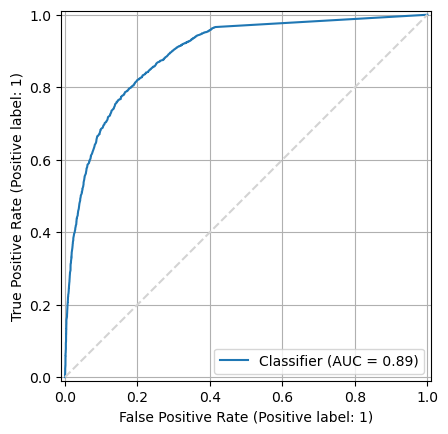

In [21]:
# 1-a) Jaccard coefficient
df_jacc = (pd.DataFrame(nx.jaccard_coefficient(G, all_pairs),
                        columns=[0, 1, "jaccard"]))
df_tmp  = df_edgelist.merge(df_jacc, how="left").fillna({"jaccard": 0})
df_no_loops["jaccard"] = create_predictions(df_tmp, df_test, ["jaccard"])

# Instead of nx.jaccard_coefficient, you can use others such as nx.preferential_attachment

## PART 2. BASED ON PATHS
Methods that consider paths of different lengths between nodes.

Model coefficients
Intercept: -2.43
a2:  0.73
a3:  19.57
a4: -19.65
--------------------------------------------------
AUC on the testing data: 0.795
--------------------------------------------------


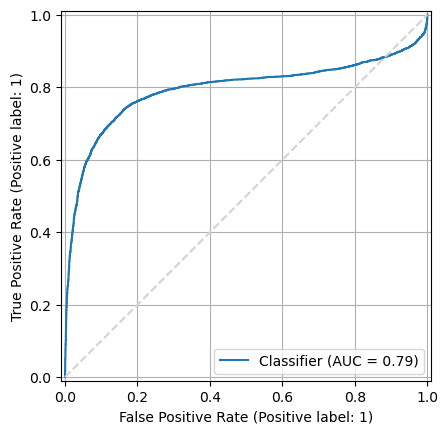

In [22]:
# %%---------------------------------------------------------------------------
# Path-count features (A², A³, …)  ──────────────────────────────────
# -----------------------------------------------------------------------------
A      = nx.to_numpy_array(G)
A2, A3, A4 = A@A, A@A@A, A@A@A@A   # paths of length 2/3/4
np.fill_diagonal(A2, 0), np.fill_diagonal(A3, 0), np.fill_diagonal(A4, 0)

df_tmp = df_edgelist.copy()
df_tmp["a2"], df_tmp["a3"], df_tmp["a4"] = A2.flatten(), A3.flatten(), A4.flatten()
df_no_loops["paths"] = create_predictions(df_tmp, df_test, ["a2", "a3", "a4"])


A more sophisticated method is Katz similarity. The Katz Similarity between two nodes i and j is the sum of the number of walks of __all lengths__ between i and j, but the walks are weighted exponentially decreasing weights based on their lengths. The intuition is that a higher number of short walks between two nodes indicate a stronger connection.

Beta: 0.011148915623848349
Model coefficients
Intercept: -1.72
katz:  2.44
--------------------------------------------------
AUC on the testing data: 0.856
--------------------------------------------------


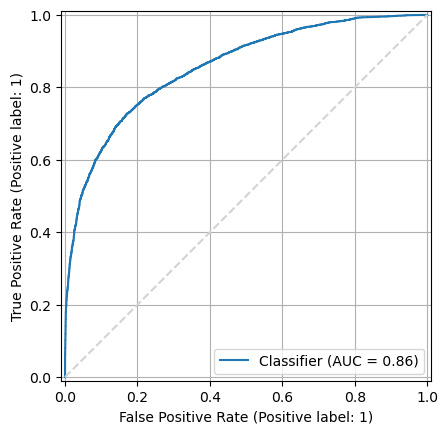

In [23]:
def katz_similarity(g, beta=None, safety=0.95):
    """
    Compute the Katz similarity matrix for a given graph.
    The Katz similarity is defined as:
    S = (I - beta*A)^(-1) - I
    where A is the adjacency matrix, I is the identity matrix, and beta is a damping
    factor that controls the influence of longer paths.
    The parameter `safety` ensures that the spectral radius of (I - beta*A)
    is less than 1, which is necessary for convergence."""
    A = nx.to_numpy_array(G)
    if beta is None:
        beta = safety / max(abs(np.linalg.eigvals(A)))    # safety < 1 for convergence
    I  = np.eye(A.shape[0])
    S  = np.linalg.inv(I - beta*A) - I
    print(f'Beta: {beta}')
    return S

katz_mat          = katz_similarity(G)
df_tmp            = df_edgelist.copy()
df_tmp["katz"]    = katz_mat.ravel()
df_no_loops["katz"] = create_predictions(df_tmp, df_test, ["katz"])


# PART 3. Methods based on node embeddings (spectral methods and matrix factorization; node2vec)
The following methods will create node embeddings based on:
- spectral method and matrix factorization
- random walks and shallow networks

In order to predict a link, each pair of embeddings needs to be combined (e.g. by computing the L1 norm (np.abs(v1-v2))

In [24]:
def pairwise_L1(emb, metric = "L1"):
    """
    Fast, vectorised N×N matrix of node-to-node distances or scores.

    Parameters
    ----------
    emb : np.ndarray of shape (N, dim)
        Row-wise node embeddings.
    metric : {"L1", "sqL2", "cos"}
        • "L1"   : Σ|v_i − v_j|    (Manhattan)  
        • "sqL2" : Σ(v_i − v_j)²   (squared Euclidean – cheaper than full L2)  
        • "cos"  : 1 − cos(v_i,v_j)  (smaller = more similar)

    Returns
    -------
    np.ndarray of shape (N, N)
        Symmetric distance matrix.
    """
    if metric == "L1":
        diff = np.abs(emb[:, None] - emb)          # N×N×dim
        return diff.sum(-1)                        # N×N

    elif metric == "sqL2":
        diff = (emb[:, None] - emb) ** 2
        return diff.sum(-1)                        # N×N

    elif metric == "cos":
        # Normalise each vector to unit length once
        normed = emb / np.linalg.norm(emb, axis=1, keepdims=True)
        # cosine(i,j) = v_i · v_j  ⇒  distance = 1 − cosine
        return 1 - np.einsum("ik,jk->ij", normed, normed)

## PART 3.1 Spectral methods

* Shows an example of a spectral method (you can try different methods: TruncatedSVD, PCA, SpectralEmbedding; you can modify the dimension of the embedding as well)

* Try different time of embeddings sizes (n_components)

Model coefficients
Intercept: -0.32
svd:  0.73
--------------------------------------------------
AUC on the testing data: 0.755
--------------------------------------------------


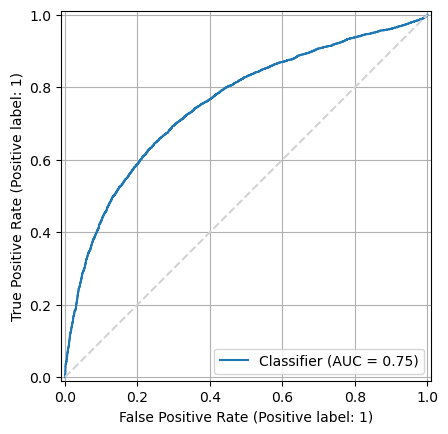

In [25]:
# Find embeddings using SVD
# 3.1-a) SVD embeddings  (dim = 10)
svd = TruncatedSVD(n_components=10).fit(nx.to_numpy_array(G))
emb = svd.components_.T                                          # node × dim

# e.g. 
# clusters_svd = SpectralEmbedding(affinity = 'precomputed', n_components=5)
# clusters_svd.fit(A)
# cl_svd = clusters_svd.embedding_

dist_mat          = pairwise_L1(emb)
df_tmp            = df_edgelist.copy()
df_tmp["svd"]     = dist_mat.ravel()
df_no_loops["svd"] = create_predictions(df_tmp, df_test, ["svd"])

## PART 3.2 Example with node2vec

You can create and save more predictions by changing the q and p parameters, the length of walks, etc

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Model coefficients
Intercept: -2.50
node2vec: -2.41
--------------------------------------------------
AUC on the testing data: 0.861
--------------------------------------------------


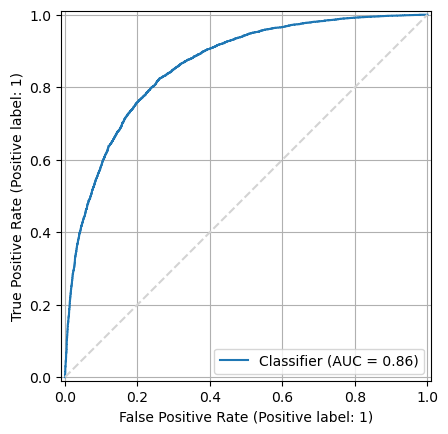

In [ ]:
# # Generate walks
# n2v = Node2Vec(G, dimensions=64, walk_length=30,
#                num_walks=10, workers=4, quiet=False).fit(window=5, min_count=1)
# emb = np.vstack([n2v.wv.get_vector(str(n)) for n in G.nodes()])


# dist_mat          = pairwise_L1(emb)
# df_tmp            = df_edgelist.copy()
# df_tmp["node2vec"] = dist_mat.ravel()
# df_no_loops["node2vec"] = create_predictions(df_tmp, df_test, ["node2vec"])



# FINAL. Stacking classifiers and exploring predictions
For each method we fitted a logisticregression, which returned a probability of two nodes being connected. 

We can now fit a meta-classifier, which takes those predictions and combines them in order to (hopefully) create a better classifier.

You can try different algorithms apart from LogisticRegressionCV: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

You can look at our results and explore which proteins may be interacting 



Meta-model using: ['jaccard', 'paths', 'katz', 'svd', 'node2vec']
Model coefficients
Intercept: -5.02
jaccard: -0.49
paths:  1.05
katz:  1.18
svd: -1.04
node2vec:  1.03
--------------------------------------------------
AUC on the testing data: 0.872
--------------------------------------------------


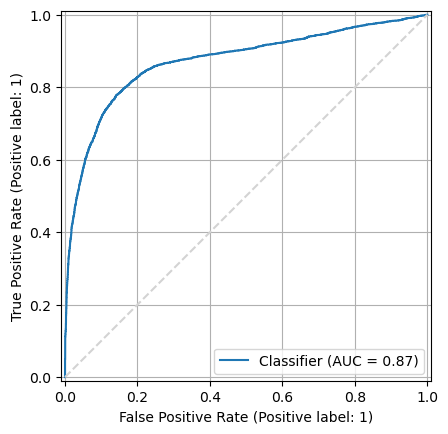

In [ ]:
## Stacking / meta-classifier  ───────────────────────────────────────-
feature_cols = ["jaccard",  "paths", "katz", "svd"]#, "node2vec"]
print("\nMeta-model using:", feature_cols)
meta_preds   = create_predictions(df_no_loops, df_test, feature_cols, return_test=True)


In [28]:

# Show a few of the strongest novel suggestions
display(meta_preds.query("label == 0").sort_values("pred_prob", ascending=False).head(20))


,0,1,source,target,label,pred_prob,pred
9157,172,364,PerrottaDaniela,elisa_omodei,0,0.989194,1
12147,328,456,mtizzoni,nerdsitu,0,0.989184,1
9000,560,645,ceu,Vesteur,0,0.969234,1
8445,235,393,all_are,spcornelius,0,0.964409,1
8886,642,878,AnisabelBento,uvmmathstats,0,0.963689,1
9854,788,6,DoctorJosh,aliceschwarze,0,0.960831,1
9197,245,256,AlicePatania,eleanorapower,0,0.959317,1
10932,159,489,adilson_motter,redcompleja,0,0.957927,1
11693,410,118,meeadsaberi,estebanmoro,0,0.953628,1
9703,347,605,jacrickets,SamirSuweis,0,0.953269,1


https://yeastgenome.org/locus/YNL288W

## PART 3.3 Example of Graph Neural Networks (graphSAGE )

The power of GNNs comes from their ability to use the structure of the graph, and the relationships between nodes, to improve their predictions or understanding of the data. They work by updating each node's features based on the features of its neighbors, allowing information to flow across the graph. This is particularly useful when we want to understand the context of a node, as defined by its location within a larger network.


Training started…

Epoch 05 | Loss 0.6806 | Test AUC 0.8103
Epoch 10 | Loss 0.5594 | Test AUC 0.8310
Epoch 15 | Loss 0.5177 | Test AUC 0.8484
Epoch 20 | Loss 0.4805 | Test AUC 0.8501
Epoch 25 | Loss 0.4726 | Test AUC 0.8479
Epoch 30 | Loss 0.4661 | Test AUC 0.8507
Epoch 35 | Loss 0.4598 | Test AUC 0.8535
Epoch 40 | Loss 0.4575 | Test AUC 0.8559
Epoch 45 | Loss 0.4517 | Test AUC 0.8586
Epoch 50 | Loss 0.4454 | Test AUC 0.8631

Training complete



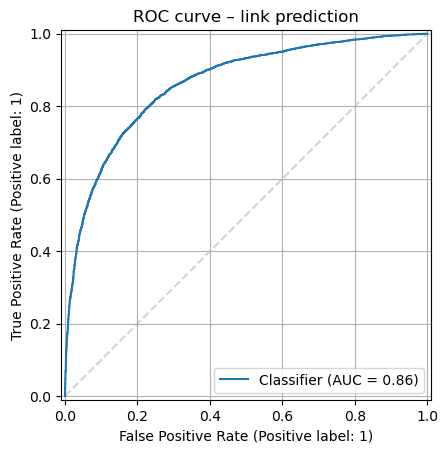

AUC on the testing data: 0.86


,source,target,label,pred
8800,TahaYasseri,svscarpino,0.0,4.298049
7835,barabasi,gesis_org,0.0,3.865493
10271,netsci2018,dinacmistry,0.0,3.824230
9760,ISI_Fondazione,davidlazer,0.0,3.728978
9159,gesis_org,alexvespi,0.0,3.682779
12050,hyejin_youn,ciro,0.0,3.614720
11043,sfiscience,pholme,0.0,3.486542
7047,clauwa,ecozzo,0.0,3.442799
7219,noshir,MartonKarsai,0.0,3.436563
10134,joel_c_miller,tinaeliassi,0.0,3.416765


In [29]:
# ---------------------------------------------------------------
# 1.  Build a PyG graph (`Data` object)
# ---------------------------------------------------------------
np.random.seed(1546)
torch.manual_seed(1546)

if network == "ppi":
    df_edges = pd.read_csv(
        "https://github.com/jgarciab/NetworkScience/raw/main/Data/CCSB-Y2H.txt",
        skiprows=1, sep="\t", header=None
    )
else:
    df_edges = pd.read_csv(
        "https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ic2s2_netsci_3.tsv",
        sep="\t", usecols=["source", "target"]
    )
    df_edges.columns = [0, 1]

# Make the graph undirected (add “B→A” for every “A→B”)
df_edges = pd.concat([df_edges, df_edges.rename(columns={0: 1, 1: 0})])

# Build a NetworkX graph and drop self-loops (A→A)
G_nx = nx.from_pandas_edgelist(df_edges, source=0, target=1)
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Keep **only** the largest connected group of nodes
G_nx = G_nx.subgraph(max(nx.connected_components(G_nx), key=len)).copy()

# Relabel node names (which could be strings) to 0,1,2,…
node_map = {old: new for new, old in enumerate(sorted(G_nx.nodes()))}
edges_df = (pd.DataFrame(G_nx.edges())
              .rename(columns={0: "src", 1: "dst"}))
edges_df["src"] = edges_df["src"].map(node_map)
edges_df["dst"] = edges_df["dst"].map(node_map)

# Duplicate again so (src,dst) and (dst,src) are explicitly stored
edges_df = pd.concat(
    [edges_df, edges_df.rename(columns={"src": "dst", "dst": "src"})]
).drop_duplicates()

num_nodes = len(node_map)                     # total unique users/proteins
edge_index = torch.tensor(edges_df.values.T,  # shape [2, num_edges]
                          dtype=torch.long)

# **Node features** – here we use a one-hot identity matrix.
# In real life you would load profile text, protein domains, etc.
x = torch.eye(num_nodes)

# Wrap everything into a PyG “Data” object
data = Data(x=x, edge_index=edge_index)

# ------------------------------------------------------------
# 2. CREATE TRAIN / TEST / NEGATIVE EDGE SPLITS
# ------------------------------------------------------------
# Split **positive** edges (real ones) 90 % / 10 %
u = edges_df["src"].values
v = edges_df["dst"].values
perm = np.random.permutation(len(u))
test_size = int(0.10 * len(u))

train_pos_u, test_pos_u = u[perm[test_size:]], u[perm[:test_size]]
train_pos_v, test_pos_v = v[perm[test_size:]], v[perm[:test_size]]

train_pos_edge = torch.tensor(
    np.stack([train_pos_u, train_pos_v]), dtype=torch.long
)

# Generate the *same* number of **negative** edges (non-existing pairs)
neg_edge_all = negative_sampling(
    edge_index=train_pos_edge,
    num_nodes=num_nodes,
    num_neg_samples=len(u),   # equal to number of positives
    method="sparse",
)
neg_u, neg_v = neg_edge_all.cpu().numpy()

train_neg_u, test_neg_u = neg_u[test_size:], neg_u[:test_size]
train_neg_v, test_neg_v = neg_v[test_size:], neg_v[:test_size]

train_neg_edge = torch.tensor(
    np.stack([train_neg_u, train_neg_v]), dtype=torch.long
)
test_pos_edge = torch.tensor(
    np.stack([test_pos_u, test_pos_v]), dtype=torch.long
)
test_neg_edge = torch.tensor(
    np.stack([test_neg_u, test_neg_v]), dtype=torch.long
)

# ------------------------------------------------------------
# 3. DEFINE THE GRAPH NEURAL-NETWORK COMPONENTS
# ------------------------------------------------------------
class GraphSAGE(nn.Module):
    """
    Simple 2-layer GraphSAGE encoder
    --------------------------------
    Turns every node into a *d*-dimensional vector embedding by
    repeatedly averaging (’mean’) over its neighbours.
    
    Parameters
    ----------
    in_dim : int
        Size of the input feature for each node (here: num_nodes
        because we used an identity matrix).
    hidden_dim : int
        Size of the hidden & output embedding we want to learn.
    """
    def __init__(self, in_dim: int, hidden_dim: int, drop_p: float = 0.3):
        super().__init__()
        self.conv1 = SAGEConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            aggr="mean",      # neighbour aggregator
        )
        self.conv2 = SAGEConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            aggr="mean",
        )
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Run the two message-passing layers.
        
        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape ``[num_nodes, in_dim]``.
        edge_index : torch.Tensor
            Edge list of shape ``[2, num_edges]``.
        
        Returns
        -------
        torch.Tensor
            Final node embeddings of shape ``[num_nodes, hidden_dim]``.
        """
        h = F.relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)
        h = self.dropout(h)
        return h

class MLPPredictor(nn.Module):
    """
    Edge-score predictor
    --------------------
    Tiny 2-layer perceptron that takes two node embeddings
    (source & destination), concatenates them and outputs a
    single logit score ∈ ℝ.  Higher ⇒ more likely the link is real.
    """
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.lin1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor,
                edge_index: torch.Tensor) -> torch.Tensor:
        """
        Compute a score for each edge in *edge_index*.
        
        Parameters
        ----------
        h : torch.Tensor
            Node embeddings ``[num_nodes, hidden_dim]``.
        edge_index : torch.Tensor
            Edges to score ``[2, num_edges]``.
        
        Returns
        -------
        torch.Tensor
            Flat tensor of length ``num_edges`` with raw scores
            (logits – we will feed them to `BCEWithLogitsLoss`).
        """
        h_src = h[edge_index[0]]      # embeddings for edge sources
        h_dst = h[edge_index[1]]      # embeddings for edge targets
        h_pair = torch.cat([h_src, h_dst], dim=-1)
        out = self.lin2(F.relu(self.lin1(h_pair)))
        return out.view(-1)           # shape → (num_edges,)

def binary_loss(pos_score: torch.Tensor,
                neg_score: torch.Tensor) -> torch.Tensor:
    """
    Standard binary-cross-entropy loss for link prediction.
    """
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones_like(pos_score),
                        torch.zeros_like(neg_score)])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score: torch.Tensor,
                neg_score: torch.Tensor) -> float:
    """
    Area-Under-ROC for easy monitoring during training.
    """
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat([torch.ones_like(pos_score),
                        torch.zeros_like(neg_score)]).cpu().numpy()
    return roc_auc_score(labels, scores)

# ------------------------------------------------------------
# 4. TRAIN THE MODEL
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data and edges to CPU / GPU
data = data.to(device)
train_pos_edge, train_neg_edge = train_pos_edge.to(device), train_neg_edge.to(device)
test_pos_edge,  test_neg_edge  = test_pos_edge .to(device), test_neg_edge .to(device)

# Initialise the networks
model = GraphSAGE(data.num_node_features, hidden_dim=32).to(device)
predictor = MLPPredictor(hidden_dim=32).to(device)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor.parameters()),
    lr=0.01,
)

print("\nTraining started…\n")
for epoch in range(1, 51):      # 25 epochs
    model.train()
    optimizer.zero_grad()

    # 1) Embed nodes *using only training edges*
    h = model(data.x, train_pos_edge)

    # 2) Score positive & negative edges
    pos_score = predictor(h, train_pos_edge)
    neg_score = predictor(h, train_neg_edge)

    # 3) Back-propagation step
    loss = binary_loss(pos_score, neg_score)
    loss.backward()
    optimizer.step()

    # Every 5 epochs ➜ check AUC on the 10 % held-out edges
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            h = model(data.x, train_pos_edge)     # fresh forward pass
            test_pos_score = predictor(h, test_pos_edge)
            test_neg_score = predictor(h, test_neg_edge)
            print(f"Epoch {epoch:02d} | "
                  f"Loss {loss.item():.4f} | "
                  f"Test AUC {compute_auc(test_pos_score, test_neg_score):.4f}")

print("\nTraining complete\n")

# ------------------------------------------------------------
# 5. BUILD A FRIENDLY TEST TABLE + ROC CURVE
# ------------------------------------------------------------
# Build a DataFrame for easier human inspection
df_test_gnn = pd.DataFrame({
    "source": np.concatenate([test_pos_u, test_neg_u]),
    "target": np.concatenate([test_pos_v, test_neg_v]),
    "label" : np.concatenate([np.ones(len(test_pos_u)),
                              np.zeros(len(test_neg_u))]),
})

# Compute final scores
with torch.no_grad():
    h = model(data.x, train_pos_edge)
    df_test_gnn["pred"] = np.concatenate([
        predictor(h, test_pos_edge).cpu().numpy(),
        predictor(h, test_neg_edge).cpu().numpy(),
    ])

# Map the numeric node IDs back to the original names/usernames
inverse_map = {v: k for k, v in node_map.items()}
df_test_gnn["source"] = df_test_gnn["source"].map(inverse_map)
df_test_gnn["target"] = df_test_gnn["target"].map(inverse_map)

# Plot ROC curve
RocCurveDisplay.from_predictions(df_test_gnn["label"], df_test_gnn["pred"])
plt.plot([0, 1], [0, 1], "--", color="lightgray", zorder=0)  # diagonal reference
plt.title("ROC curve – link prediction")
plt.grid(True)
plt.show()

# Print AUC
auc = roc_auc_score(df_test_gnn["label"], df_test_gnn["pred"])
print(f"AUC on the testing data: {auc:.2f}")


# Show a few of the strongest novel suggestions
display(df_test_gnn.query("label == 0").sort_values("pred", ascending=False).head(20))


## This is how we created the network

In [30]:
def create_network_train_test(df, net_name="twitter"):
    df = pd.concat([df, df.rename(columns={0:1, 1:0})])

    G = nx.from_pandas_edgelist(df, source=0, target=1)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    df = pd.DataFrame(G0.edges())
    df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()

    nodes = df[0].unique()
    d_conv = dict(zip(nodes, range(len(nodes))))
    df[0] = df[0].map(d_conv)
    df[1] = df[1].map(d_conv)

    G = nx.from_pandas_edgelist(df, source=0, target=1)

    adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))

    u,v = np.nonzero(adj)
    eids = np.arange(len(u))
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = len(u) - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj_neg =  adj.todense() + np.eye(len(G)) - 1
    neg_u, neg_v = np.nonzero(adj_neg)

    neg_eids = np.random.choice(len(neg_u), len(u))
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    # Positive and negative examples to test (50-50)
    pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
    pos["label"] = 1
    neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
    neg["label"] = 0
    df_test = pd.concat([pos,neg])
    len(df_test)

    df_test.to_csv(f"{path_data}{net_name}_network_prediction_test.csv", sep="\t")

    # Network with 10% removed
    G.remove_edges_from(zip(test_pos_u, test_pos_v))
    nx.set_node_attributes(G, {v:k for k,v in d_conv.items()}, name="label")
    nx.write_graphml(G, f"{path_data}{net_name}_network_prediction.graphml")

if 0: #don't run it
    np.random.seed(1546)
    # Create network for challenge (Twitter)
    df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0,1]
    create_network_train_test(df, net_name="twitter")

    np.random.seed(1546)
    # Create network for challenge (PPI)
    df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
    create_network_train_test(df, net_name="ppi")